# Exploring datasets with absolute measurements

In [1]:
import numpy as np
import pandas as pd
import bokeh.io
import bokeh.plotting
import bokeh.models
import bokeh.transform
import bokeh.palettes
import prot.viz
import altair as alt
import panel as pn
colors, palette = prot.viz.bokeh_theme()
import imp

imp.reload(prot.viz)
prot.viz.altair_theme()
bokeh.io.output_notebook()
pn.extension('vega')
alt.data_transformers.enable('default')
stroke_defaults = {'stroke':alt.value('black'), 'strokeWidth': alt.value(0.75)}

Loading BokehJS ...

After a few days of work, Nathan and I have collated a number of proteomics data sets of *E. coli* under different conditions with different goals in mind. A subset of these data sets use *absolute* protein count measurements while others report measurements in arbitrary units or things like "copy number per fL" without any actual measurement of the cell volume. In this notebook, we'll explore a few different features of the datasets which report their measurements in *absolute measurements per cell.*  Using the UniProt annotations for the molecualr weight, I calculated the total weight in terms of femtograms per cell. 

In this notebook, I will explore some of the large-scale trends in the data including the sectoring phenomena. Additionally, I'll look at how the scaling of particular molecular species "such as sugar transporers, ribosomal components, etc.) scale as a function of growth rate. Using some order-of-magnitude estimates, we should be able to use these data sets to really test the hypotheses of "what sets the speed limit of bacterial growth."


## Part I: Sectoring of the proteome by COGs
In Schmidt *et al.* 2016, the authors classified each gene product by their Clusters of Orthologous Groups identification (COGs). This associates genes with their associated biological functions. In some cases, genes are annotated as being involved in two different processes, which is valid. Using this same approach, we have associated all of the genes in three five different datasets under the same scheme. If a gene is listed in two different processes, then we duplicate it in the data set. THis means that we need to keep track of the copy number of *unique* proteins rather than a simple summation. This should be relatively easy to do. 


### COG categories and their growth-rate dependence. 

To begin, we will load in this dat set and break down the total mass, total copy number, and fractional occupancy of the proteome by the four unique COG categories, 

1. Information Storage and Processing: This includes ribosomes, polymerases, tRNA synthetases, transcription factors, etc. 
2. Metabolism: Everything involved in breaking down carbonaceous molecules to make ATP. 
3. Cellular Processes and Signaling: This includes chemotaxis, signaling, protein maintenance/degradation, etc.
4. Poorly characterized: All proteins with unknown or poorly characterized function. 
5. Not Assigned: this is my classification for genes that could not be found with a functional COG association. These can probably be linked in with "Poorly Characterized" above. 

In [2]:
# Load the dataset with aboslute measurements
data = pd.read_csv('../../data/compiled_absolute_measurements.csv')

# Group by each dataset, condition, and cog class and compute the mass and count fraction. 
class_fraction = pd.DataFrame([])
for g, d in data.groupby(['dataset', 'condition', 'growth_rate_hr']):
    
    # Get the total mass and size of the proteome.  
    tot_mass = d['fg_per_cell'].sum()
    tot_count = d['tot_per_cell'].sum()
    
    for _g, _d in d.groupby('cog_class'):  
        # Compute the count, mass, and fractions. 
        cat_count = _d['tot_per_cell'].sum()
        cat_mass = _d['fg_per_cell'].sum()
        cat_count_frac = cat_count / tot_count
        cat_mass_frac = cat_mass / tot_mass
        
        # Set up the statistics dictionary and save. 
        class_fraction = class_fraction.append({
                'cog_class':_g,
                'dataset':g[0],
                'condition':g[1],
                'growth_rate_hr': g[-1],
                'proteome_mass': tot_mass,
                'proteome_size': tot_count,
                'category_mass': cat_mass,
                'category_size': cat_count,
                'category_frac_mass': cat_mass_frac,
                'category_frac_size': cat_count_frac
                }, ignore_index=True)
 


In [3]:
data[data['dataset']=='peebo_2015']['growth_rate_hr'].unique()

array([0.21, 0.22, 0.25, 0.26, 0.31, 0.35, 0.36, 0.41, 0.42, 0.45, 0.46,
       0.51, 0.53, 0.55, 0.63, 0.65, 0.73, 0.74, 0.78, 0.82])

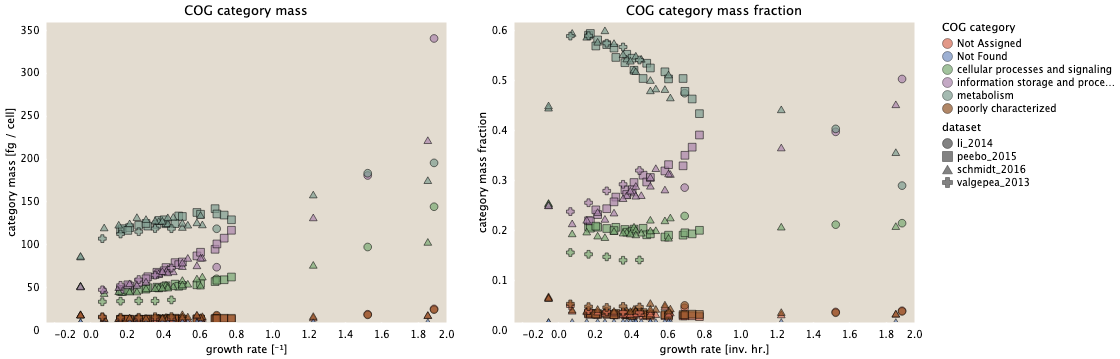

In [4]:
# Define the chart base
base = alt.Chart(class_fraction, width=400, height=300)


# Add points for the category mass
tot_mass = base.mark_point(size=60
        ).encode(
            y=alt.Y('category_mass', 
                    axis=alt.Axis(title='category mass [fg / cell]')),
            x=alt.X('growth_rate_hr', 
                    axis=alt.Axis(title='growth rate [\u207b\u00b9]')),
            fill=alt.Color('cog_class:N', legend=alt.Legend(title='COG category')),
            tooltip=['dataset', 'condition', 'growth_rate_hr', 'cog_class'],
            shape='dataset:O',
            **stroke_defaults
        ).properties(
            title='COG category mass'
        ).interactive()

# Add points for the category fractional mass 
frac_mass = base.mark_point(size=60).encode(
            y=alt.Y('category_frac_mass', 
                    axis=alt.Axis(title='category mass fraction')),
            x=alt.X('growth_rate_hr', 
                    axis=alt.Axis(title='growth rate [inv. hr.]')),
            fill=alt.Color('cog_class:N', legend=alt.Legend(title='COG category')),
            tooltip=['dataset', 'condition', 'growth_rate_hr', 'cog_class'],
            shape='dataset:O',
            **stroke_defaults
    ).properties(
    title='COG category mass fraction'
    ).interactive()

chart = alt.hconcat(tot_mass, frac_mass)
chart

This matches what we've seen in the schmidt dataset. The sector dedicated to "Information Storage and Processing" is anticorrelated with the "Metabolism" sector. Let's now look at how these two different categories compare with one another. This time, we'll use shape to denote the data set, but the color will denote the growth rate. 

In [5]:
correlation_df = []
for g, d in class_fraction.groupby(['dataset']):
    d = d.copy()
    d.sort_values(by='growth_rate_hr', inplace=True)
    info = d[d['cog_class'].str.lower() == 'information storage and processing']
    metab = d[d['cog_class'].str.lower() =='metabolism']
    _d = pd.DataFrame(np.array([info['category_frac_mass'].values, info['category_frac_size'].values,
                                metab['category_frac_mass'].values, metab['category_frac_size'].values,
                                info['growth_rate_hr'].values]).T, 
                                columns=['info_frac_mass', 'info_frac_size',
                                         'metab_frac_mass', 'metab_frac_size',
                                         'growth_rate_hr'])
    _d['dataset'] = g
    _d['condition']= info['condition'].values
    correlation_df.append(_d)
    
info_metab_correlation =  pd.concat(correlation_df, sort=False)

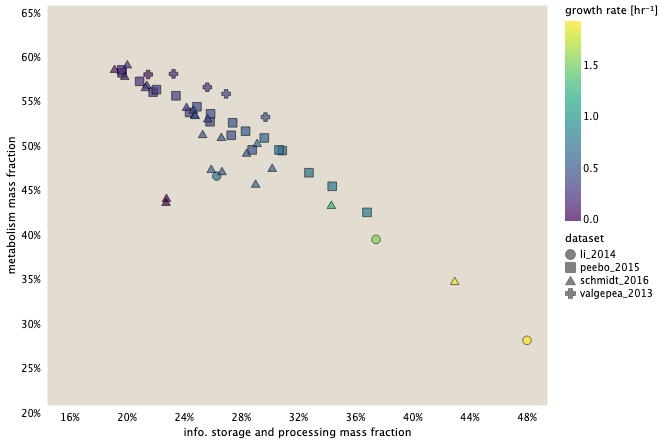

In [6]:
# Group bygrowth rate bins of 0.1 inv hr. 
# info_metab_correlation['bins'] = pd.cut(info_metab_correlation['growth_rate_hr'], bins=np.arange(-0.01, 2, 0.01))
# agg = info_metab_correlation.groupby('bins').mean().reset_index()
# agg.drop(labels='bins', inplace=True, axis=1)
# agg = agg[~agg['info_frac_mass'].isnull()]
base = alt.Chart(info_metab_correlation, width=500, height=400)

# Define the defaults
defaults =  {'fill':alt.Color('growth_rate_hr', scale=alt.Scale(scheme='viridis'), legend=alt.Legend(title='growth rate [hr\u207b\u00b9]'))}

frac_mass = base.mark_point(size=75).encode(
            x=alt.X('info_frac_mass', 
                    axis=alt.Axis(format='%', title='info. storage and processing mass fraction'),
                   scale=alt.Scale(domain=[0.15, 0.5])),
            y=alt.Y('metab_frac_mass', 
                    axis=alt.Axis(format='%', title='metabolism mass fraction'),
                   scale=alt.Scale(domain=[0.2, 0.65])),
            shape='dataset:O',
            **defaults, **stroke_defaults
        ).interactive()


# frac_mass.save('../../figures/info_metab_mass_fraction.png', scale_factor=2.0)
# frac_mass.save('../../figures/info_metab_mass_fraction.html')
frac_mass

This again jibes with what we have seen before in hte Schmidt data alone. There is nothing that really looks like an outlying data set, save for *maybe* Valgpea 2013. Now, let's look at how individual elements scale as a function of growth rate.


## Exploring the fractionation as a function of growth rate
I think normalized stacked bar charts will be a good way to examine how the proteome fraction changes from condition to condition


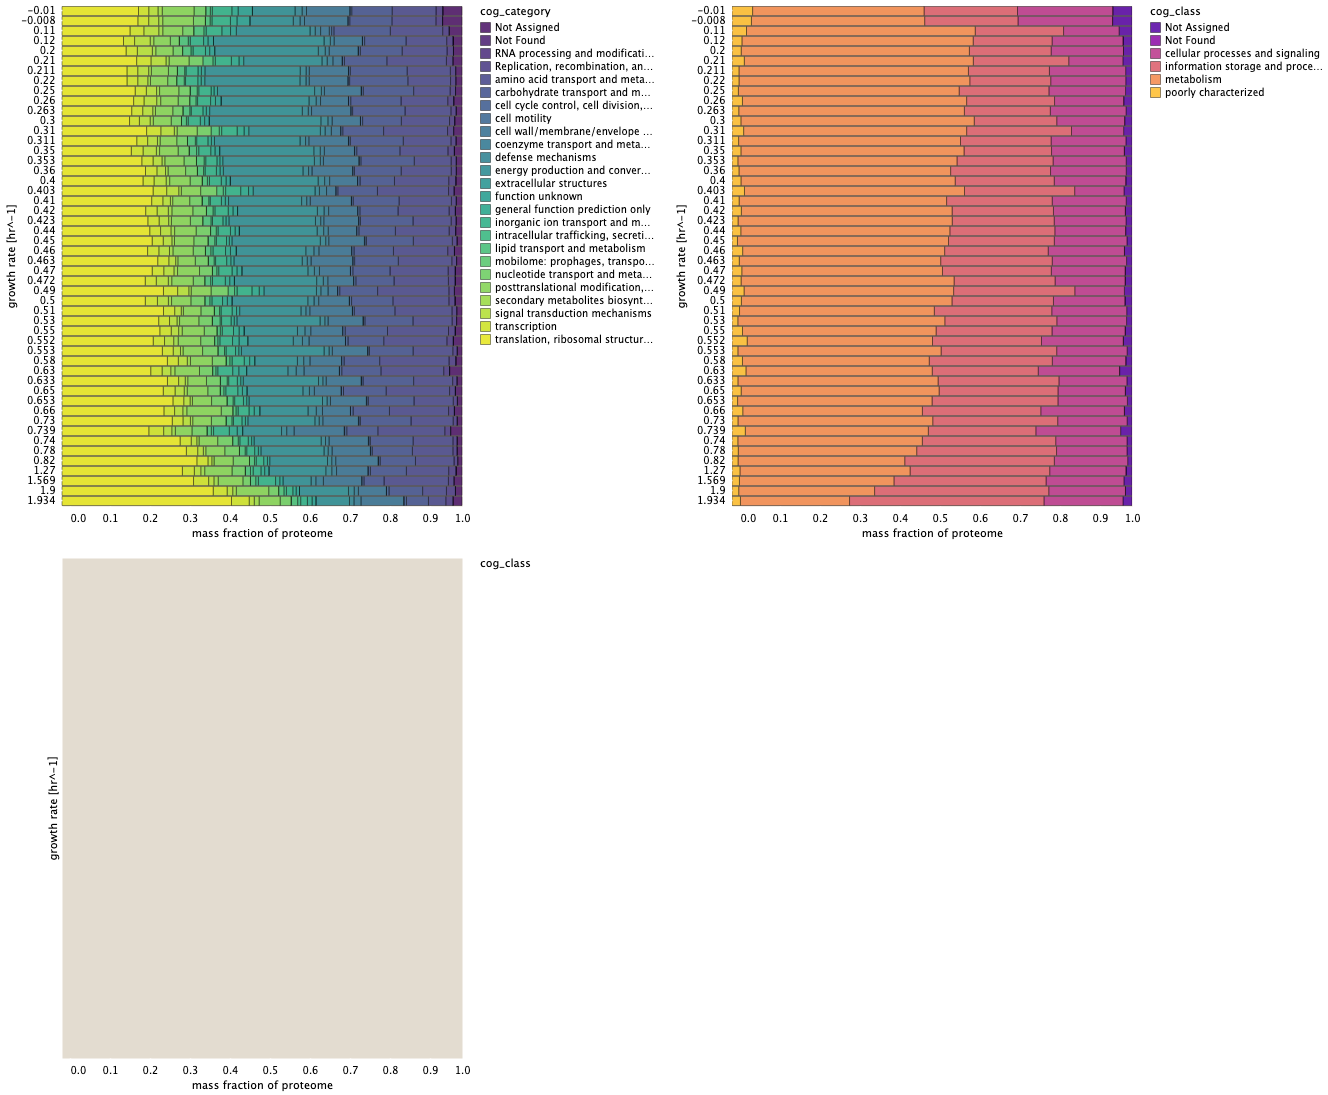

In [7]:
# Compute the total mass fraction for each
jittered = []
for g, d in data.groupby(['growth_rate_hr']):
    d = d.copy()
    shift = 0
    if len(d['dataset'].unique()) >= 1:
        shift += 0.001
        for _d in d['dataset'].unique()[1:]:
            d.loc[d['dataset']==_d, 'growth_rate_hr'] += shift
    if len(d['condition'].unique()) > 1:
        shift += 0.001
        for _d in d['condition'].unique()[1:]:
            d.loc[d['condition']==_d, 'growth_rate_hr'] += shift
    jittered.append(d) 
agg = pd.concat(jittered, sort=False)
agg['growth_rate_hr'] = np.round(agg['growth_rate_hr'].values, decimals=3)
classes = agg.groupby(['growth_rate_hr', 'condition', 'dataset', 'cog_category'])['fg_per_cell'].sum().reset_index()
cats = agg.groupby(['growth_rate_hr', 'condition', 'dataset', 'cog_class'])['fg_per_cell'].sum().reset_index()
info = agg[agg['cog_category']=='Information Storage and Processing'].groupby(
            ['growth_rate_hr', 'condition', 'dataset', 'cog_class'])['fg_per_cell'].sum().reset_index()

class_bars = alt.Chart(classes, height=500).mark_bar().encode(
    x=alt.X('fg_per_cell:Q', stack="normalize", axis={'title':'mass fraction of proteome'}),
    y=alt.Y('growth_rate_hr:O', axis={'title': 'growth rate [hr^-1]', 'labelAngle':0}),
    color=alt.Color('cog_category:N', scale={'scheme':'viridis'}),
    tooltip=['dataset', 'cog_category', 'condition', 'fg_per_cell'],
    opacity=alt.value(0.85))

cat_bars = alt.Chart(cats, height=500).mark_bar().encode(
    x=alt.X('fg_per_cell:Q', stack="normalize", axis={'title':'mass fraction of proteome'}),
    y=alt.Y('growth_rate_hr:O', axis={'title': 'growth rate [hr^-1]', 'labelAngle':0}),
    color=alt.Color('cog_class:N', scale={'scheme':'plasma'}),
    tooltip=['dataset', 'cog_class', 'condition', 'fg_per_cell'],
    opacity=alt.value(0.85)).interactive()

info_bars = alt.Chart(info, height=500).mark_bar().encode(
    x=alt.X('fg_per_cell:Q', stack="normalize", axis={'title':'mass fraction of proteome'}),
    y=alt.Y('growth_rate_hr:O', axis={'title': 'growth rate [hr^-1]', 'labelAngle':0}),
    color=alt.Color('cog_class:N', scale={'scheme':'bluepurple'}),
    tooltip=['dataset', 'cog_class', 'condition', 'fg_per_cell'],
    opacity=alt.value(0.85)).interactive()

row = alt.hconcat(class_bars , cat_bars).resolve_scale(color='independent')
col = alt.vconcat(row, info_bars).resolve_scale(color='independent')
col

#le# Scaling of ribosomal proteins
First, we'll look at how the ribosomal gene scale as a funciton of growth rate. There are a large number of proteins involved in making a ribosome. If I remember correctly, they are all in the single copy number regime, with L4 in 4 copies per cell. Let's split the dataset down to only consider the ribosomal genes. 

In [17]:
# Isolate the proteins involved in ribosome structure. 
ribo_frac = pd.DataFrame([])
for g, d in data.groupby(['condition', 'dataset', 'growth_rate_hr']):
    # Remove the duplicates to calculate total mass and size. 
    tot_mass = d['fg_per_cell'].sum()
    tot_size = d['tot_per_cell'].sum()
    
    # Isolate the ribosomal gene fraction 
    ribo = d[d['go_terms'].str.contains('GO:0005840')] 
    
    # Compute the ribosomal fractions. 
    ribo_mass = ribo['fg_per_cell'].sum()
    ribo_size = ribo['tot_per_cell'].sum()
    
    # Update the dataframe. 
    ribo_frac = ribo_frac.append({
        'tot_mass':tot_mass,
        'tot_count':tot_count,
        'ribo_mass':ribo_mass,
        'ribo_size':ribo_size,
        'frac_mass': ribo_mass / tot_mass,
        'frac_size': ribo_size / tot_size,
        'condition': g[0],
        'dataset': g[1],
        'growth_rate_hr':g[-1]},
    ignore_index=True)


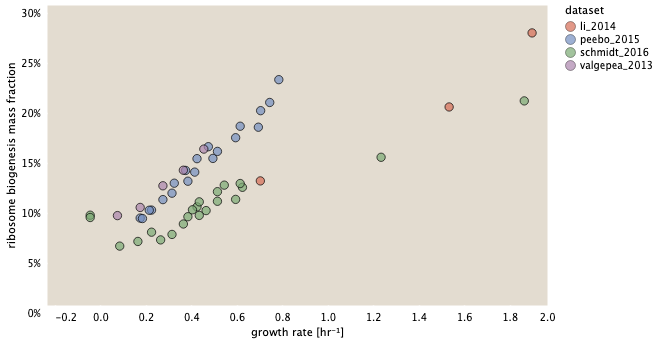

In [18]:
base = alt.Chart(ribo_frac, width=500, height=300)

# Define the defaults
defaults = {'stroke':alt.value('black'),
            'strokeWidth':alt.value(1),
            'fill':'dataset', 
            'x' : alt.X('growth_rate_hr', axis=alt.Axis(title='growth rate [hr\u207b\u00b9]')),
            'tooltip':['condition', 'dataset','growth_rate_hr']} 
           
# Encode the points. 
frac_mass = base.mark_point(size=70).encode( 
        y = alt.Y('frac_mass', axis=alt.Axis(format='%', title='ribosome biogenesis mass fraction')),
        **defaults
).interactive()

frac_mass

In [10]:
len(data['b_number'].unique())

3442

There seems to be some outlier-weirdness in the Tanguichi and Valgepea datasets. that will definitely require some more thought and dissection. 

# Part II: Copy Numbers of Molecular Constituents

With these datasets in hand, we can start to exactly measure the total copy numbers of each class of molecular species that may set the speed limit of bacterial growth. 


## Sugar Transport
A simple order-of-magnitude estimate suggests that on the order of $\approx 10^3 - 10^4$ per cell. With the GO term annotated data, we can start to look at this, although I don't understand as of yet how to deal with the oligomeric state (maybe it's okay to assume everything is a tetramer? at least as an approsimation)

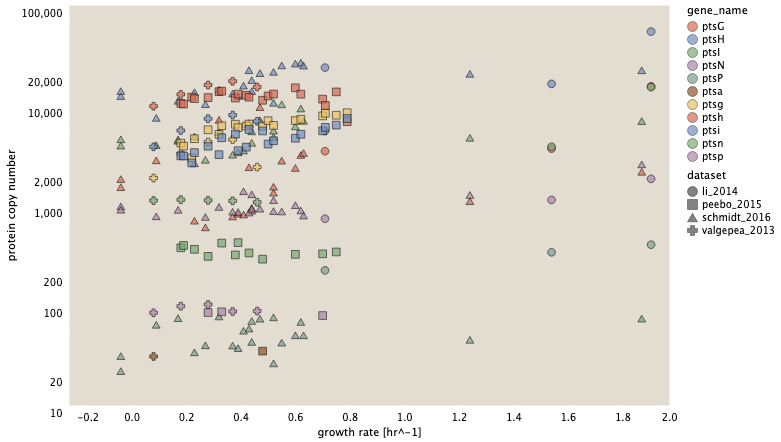

In [15]:
# Isolate the sugar transporter. 
sugar_tporter = data[data['gene_name'].str.contains('pts')]

base =  alt.Chart(sugar_tporter[sugar_tporter['tot_per_cell'] > 0], width=600, height=400)

points = base.mark_point(size=60).encode(
    x=alt.X('growth_rate_hr', axis=alt.Axis(title='growth rate [hr^-1]')),
    y=alt.Y('tot_per_cell', axis=alt.Axis(title='protein copy number'), scale=alt.Scale(type='log')), 
    fill='gene_name',
    shape='dataset',
    tooltip=['gene_name', 'condition', 'dataset'],
    **stroke_defaults).interactive()
points

# Examining single proteins 

We can also look at individual proteins in the data set in an interactive fashion

In [157]:
prots = data.copy()


gene_selector = pn.widgets.Select(name='protein', options=list(prots['gene_name'].unique()),
                                value='acrA')
@pn.depends(mut=gene_selector.param.value)
def plot_muts(mut):
    genes = prots[prots['gene_name']==mut]
    chart = alt.Chart(genes, width=500, height=200).mark_point(size=40).encode(
            x=alt.X('growth_rate_hr:Q', axis={'title':'growth rate [hr^-1]'}),
            y=alt.Y('tot_per_cell:Q', axis={'title':'copy number'}),
            fill='dataset:N',
            stroke=alt.value('black'),
            strokeWidth=alt.value(0.2),
            tooltip=['condition']
    ).properties(title=mut).interactive()
    return chart

widgets = pn.Column(gene_selector)
pn.Row(widgets, plot_muts)

Row
    [0] Column
        [0] Select(name='protein', options=['InsH-1', 'aas', ...], value='acrA')
    [1] ParamFunction(function)